
# Data Mining Course Project 1 -- 郝健乔 2018211670


## Part 1 ： 概要
本作业主要为在美国《科学》杂志上发表的一种新型聚类算法的代码实现，并对该算法进行性能的评测。

该新型聚类算法的代码实现为我独立完成，但是当对该算法与其他算法进行比较时，其他聚类算法我直接调用了sklearn中的代码实现。

本作业的参考资料包括：
1. Clustering by fast search and find of density peaks，作者：Alex Rodriguez and Alessandro Laio，期刊：27 JUNE 2014， VOL 344 ISSUE 6191，Science
2. [Demonstration of k-means assumptions — scikit-learn 0.20.2 documentation](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_assumptions.html#sphx-glr-auto-examples-cluster-plot-kmeans-assumptions-py)






In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Part 2 ：数据集与K-means算法的聚类结果

**Note：K-means聚类部分的代码及数据集均来自与sklearn的官方指南。请参见Part1概要部分的参考资料2.**

为了较好地展现新型聚类算法的特点，本作业主要采用的是sklearn中K-means算法可能不能很好得到聚类结果的数据集。K-means算法的一大不足在于需要事先制定类数k，如果k的选取不准确，那么聚类结果便会受到很大影响。即便k的选取是准确的，由于在K-means中，类与类的区分是单纯按照点与点的距离来度量的，因此当三类数据有不同的方差时，K-means得到的结果往往也会有一定偏差。

本作业选取的数据集是采用make_blobs函数生成的三类数据点，其中三类的标准差分别1.0，2.5和0.5。

### 2.1 数据集的展示

下面给出生成的数据集的真实类别的分布。

Text(0.5,1,'Unequal Variance -- Real')

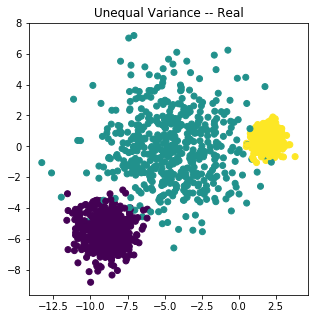

In [2]:
from sklearn.datasets import make_blobs

plt.figure(figsize=(5, 5))

n_samples = 1500
random_state = 170
X, y = make_blobs(n_samples=n_samples,
                                cluster_std=[1.0, 2.5, 0.5],
                                random_state=random_state)

plt.scatter(X[:, 0], X[:, 1], c=y)
plt.title("Unequal Variance -- Real")

### 2.2 K-means的聚类结果 -- 错误的k的选择

在利用K-means进行聚类时，如果k的选取时错误的，那么最终聚类结果会相差甚远。

Text(0.5,1,'Unequal Variance -- Kmeans with Wrong k')

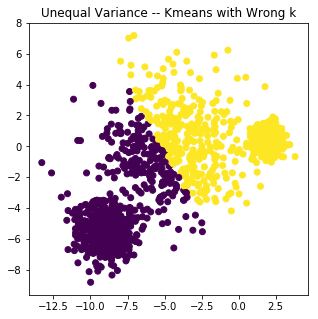

In [3]:
from sklearn.cluster import KMeans
plt.figure(figsize=(5, 5))
y_pred = KMeans(n_clusters=2, random_state=random_state).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y_pred)
plt.title("Unequal Variance -- Kmeans with Wrong k")

### 2.3 K-means的聚类结果 -- 正确的k的选择

即便选择了正确的k值，由于生成的三组数据标准差不同，K-means的表现也存在不足：由于第二类数据标准差较大，而第三类和第一类标准差很小，K-means会将很多第二类的数据分类至第三类和第一类中。尤其是下图中间一类的右侧部分，很多本该是第二类的数据点均被聚类至最靠右侧的第三类。

Text(0.5,1,'Unequal Variance -- Kmeans with Correct k')

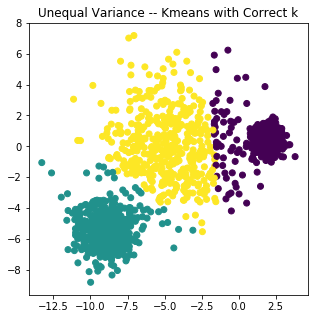

In [4]:
from sklearn.cluster import KMeans
plt.figure(figsize=(5, 5))
y_pred = KMeans(n_clusters=3, random_state=random_state).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y_pred)
plt.title("Unequal Variance -- Kmeans with Correct k")

## Part 3 ：新型聚类算法的代码实现

### 3.1 决策图（Decision Graph）的计算

在应用新型聚类算法时，画出决策图是至关重要的一步。本文先计算出了距离矩阵，并根据作者的定义，计算出各样本点的$\rho$和$\delta$值，并在计算$\delta$值时记录了与各点距离最近的密度更高的点的序号。

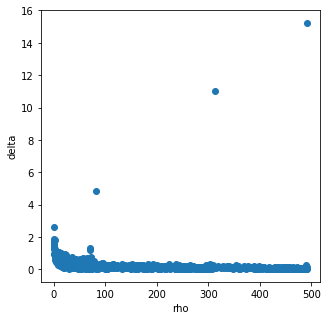

In [5]:
plt.figure(figsize=(5, 5))

# 变量定义，包括距离矩阵、rho值、delta值、与各点距离最近的密度更高的点的序号
distance = np.zeros((n_samples, n_samples))
rho = np.zeros((n_samples, 1))         
delta = np.zeros((n_samples, 1))
nearest_higher_density_index = np.zeros((n_samples, 1), dtype=np.int16)

# 距离矩阵的计算
for i in range(0, n_samples):
    for j in range(0, n_samples):
        distance[i, j] = np.sqrt(np.sum(np.square(X[i] - X[j])))
# print(distance)

# 计算临界距离dc
dc = np.percentile(distance, 15) # 作者建议选取使得平均近邻数在总样本点数1%-2%的dc，但作者也提到dc的选取对结果总体是稳健扽，考虑到距离矩阵是对陈阵，会有一定重复元素，本文在此选择将距离矩阵升序排列后的15%分位数作为dc

# 计算rho值向量
for i in range(0, n_samples):
    num = 0
    for j in range(0, n_samples):
        if j != i and distance[i][j] < dc:
            num = num + 1
    rho[i] = num
# print(rho)

# 计算delta值向量，并记录与各点距离最近的密度更高的近邻的序号
for i in range(0, n_samples):
    min_dist = 0.00
    initialize = False
    for j in range(0, n_samples):
        if j != i and rho[j] > rho[i]:
            if initialize is False:
                min_dist = distance[i][j]
                initialize = True
                nearest_higher_density_index[i] = j
            elif distance[i][j] < min_dist:
                min_dist = distance[i][j]
                initialzie = True
                nearest_higher_density_index[i] = j
            else:
                pass
    # 根据原文，对于密度最高的点，将max_j(d_ij)作为delta_i的值
    if initialize is False:
        delta[i] = np.max(distance[i])
        nearest_higher_density_index[i] = -1
    else:
        delta[i] = min_dist
# print(delta)
# print(nearest_higher_density_index)

# 画出decision-graph
plt.scatter(rho, delta)
plt.xlabel("rho")
plt.ylabel("delta")
plt.show()

### 3.2 列出$\delta$值前N大的点

由于数据集样本点众多（图示可能会有所重合），为了更好的确定类别数量及聚类中心，在本步中列出了$\delta$值前10位的点以供参考。

In [6]:
import heapq
num_of_clusters_trial = 10
largest_index_trial = heapq.nlargest(num_of_clusters_trial, range(len(delta)), delta.take)
print(largest_index_trial)
print(delta[largest_index_trial])

[1499, 1322, 301, 986, 760, 106, 180, 62, 202, 742]
[[15.25209393]
 [11.03830353]
 [ 4.85549146]
 [ 2.59888852]
 [ 1.89333414]
 [ 1.82133354]
 [ 1.70518843]
 [ 1.69647408]
 [ 1.68641286]
 [ 1.59915991]]


### 3.3 聚类

由上一步可知，在本数据集中应该选择的聚类数为3，尽管排在第4位的$\delta$值约为2.60，但由图可知，该点的$\rho$值很小，这意味着其很可能是异常值点，因此合适的类数位3。这可以很好地避免K-means中需要预先确定k值的问题。

在聚类的过程中，根据原文内容，每一点的类应该与“密度比其更高的最近邻点”所属的类相同。基于此设定，代码的实现及结果如下。

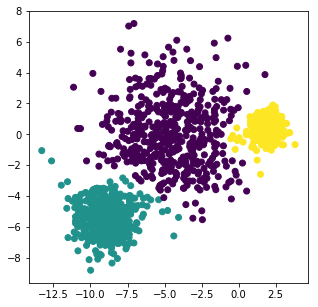

In [7]:
plt.figure(figsize=(5, 5))
number_of_clusters = 3
largest_index = largest_index_trial[0 : number_of_clusters]
# print(largest_index)

# 聚类 -- Assignment
y_pred = np.zeros((n_samples, ), dtype=np.int16)

normal_cluster_mark = 1    # 对于正常的类别来说，编号为1至num_of_clusters.
outlier_cluster_mark = number_of_clusters + 1   # 异常值的点从num_of_clusters + 1开始编号

# 为找到的聚类中心赋予初始类别编号
for i in range(0, n_samples):
    if i in largest_index:
        y_pred[i] = normal_cluster_mark
        normal_cluster_mark = normal_cluster_mark + 1
        if nearest_higher_density_index[i] < 0:
            nearest_higher_density_index[i] = n_samples + 999
    elif nearest_higher_density_index[i] < 0:
        y_pred[i] = outlier_cluster_mark
        outlier_cluster_mark = outlier_cluster_mark + 1
        nearest_higher_density_index[i] = n_samples + 999

# 为剩余所有点进行类别指派
while 1:
    flag = True
    for i in range(0, n_samples):
        if nearest_higher_density_index[i] >= n_samples or y_pred[i] > 0:  # 若该点已分类或本身就是密度最大值点，则不再进行指派
            pass
        elif y_pred[nearest_higher_density_index[i]] > 0:                  # 若其近邻已经指派完毕，则将其类别指派至当前点     
            y_pred[i] = y_pred[nearest_higher_density_index[i]]
        else:                                                              # 若仍存在未指派类别的点，记flag为False
            flag = False
    if flag is True:                                                       # 若所有点均已指派完毕，则跳出循环
        break

# print(y_pred)
plt.scatter(X[:, 0], X[:, 1], c=y_pred)


### 3.4 新型聚类结果分析

由上图可知，与K-means相比，新型聚类算法的确能够较准确地区分各类：尽管第二类的标准差很大，数据相对更加分散，这种仅根据距离与密度的方法在对分布未知的情况下仍能对第二类进行准确聚类。图中大多数的第二类的点均已被准确区分，仅有左右边界的极少部分点与数据集生成的类别不一致。由此可知，新型聚类算法的聚类结果的确有更强的优越性。

## Part 4 ：算法分析与测评

### 4.1 算法复杂度分析与测评

从总体来说，该算法至少需要计算出点与点两两之间的距离，算法的时间复杂度整体来看为$O(N^2)$。若采用矩阵形式存储，则其空间复杂度亦为$O(N^2)$.

但是，值得注意的是，原文只是提到了可以根据决策图（Decision Graph）来判断类别，此步骤并没有给出严格的计算公式（尽管作者提到聚类个数可以像DBSCAN一样自动确定，但[发表在 Science 上的一种新聚类算法 - peghoty - 博客园](https://www.cnblogs.com/peghoty/p/3945653.html)也提到说自动处理可能仍并不十分合适，因此在实现算法时我仍然是按照作者所提到的通过Decision Graph的方法确定的聚类中心，这导致对算法的时间测评上可能并不十分准确。然而，对于这一算法来说，时间开销最大的仍在计算$\rho$和$\delta$一步中，因此在进行时间测评时本文主要考察了从处理数据到画出决策图的时间作为算法运行时间。

尽管从测评结果上看，新型聚类算法的用时可能较长，但是这很很可能是由于算法实现造成的：如果对算法做进一步优化，将所有取最大最小值等操作、距离矩阵等采用堆栈等数据结构，算法的效率可能会大大增加，但从总体上说，与K-means的迭代算法相比，该算法的$O(N^2)$的时间复杂度是具有优越性的。此外，该算法在预测的准确率方面也有很高的提升，K-means即使给定正确的类别数都很难给出正确的分类，但是该算法是可以给出比较准确的聚类结果的。

In [8]:
import time

k_means_start = time.time()
plt.figure(figsize=(5, 5))
y_pred = KMeans(n_clusters=3, random_state=random_state).fit_predict(X)
k_means_end = time.time()

new_algorithm_start = time.time()
distance = np.zeros((n_samples, n_samples))
rho = np.zeros((n_samples, 1))         
delta = np.zeros((n_samples, 1))
nearest_higher_density_index = np.zeros((n_samples, 1), dtype=np.int16)
for i in range(0, n_samples):
    for j in range(0, n_samples):
        distance[i, j] = np.sqrt(np.sum(np.square(X[i] - X[j])))
dc = np.percentile(distance, 15) # 作者建议选取使得平均近邻数在总样本点数1%-2%的dc，但作者也提到dc的选取对结果总体是稳健扽，考虑到距离矩阵是对陈阵，会有一定重复元素，本文在此选择将距离矩阵升序排列后的15%分位数作为dc
for i in range(0, n_samples):
    num = 0
    for j in range(0, n_samples):
        if j != i and distance[i][j] < dc:
            num = num + 1
    rho[i] = num
for i in range(0, n_samples):
    min_dist = 0.00
    initialize = False
    for j in range(0, n_samples):
        if j != i and rho[j] > rho[i]:
            if initialize is False:
                min_dist = distance[i][j]
                initialize = True
                nearest_higher_density_index[i] = j
            elif distance[i][j] < min_dist:
                min_dist = distance[i][j]
                initialzie = True
                nearest_higher_density_index[i] = j
            else:
                pass
    # 根据原文，对于密度最高的点，将max_j(d_ij)作为delta_i的值
    if initialize is False:
        delta[i] = np.max(distance[i])
        nearest_higher_density_index[i] = -1
    else:
        delta[i] = min_dist
new_algorithm_end = time.time()

print("The time for k-means is %.4f seconds" % (k_means_end - k_means_start))
print("The time for new cluster algorithm is %.4f seconds" % (new_algorithm_end - new_algorithm_start))

The time for k-means is 0.0232 seconds
The time for new cluster algorithm is 16.6297 seconds


<Figure size 360x360 with 0 Axes>

### 4.2 dc的敏感度 -- dc取距离矩阵的10%分位数

从总体上来说，dc的选择可能会导致聚类结果有比较大的差异。下面给出了当dc取距离矩阵的10%分位数的聚类结果。

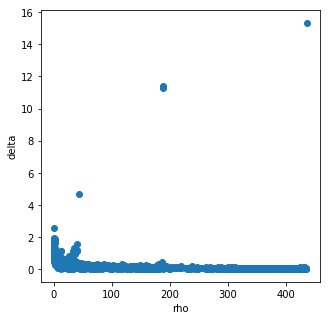

In [9]:
plt.figure(figsize=(5, 5))

# 变量定义，包括距离矩阵、rho值、delta值、与各点距离最近的密度更高的点的序号
distance = np.zeros((n_samples, n_samples))
rho = np.zeros((n_samples, 1))         
delta = np.zeros((n_samples, 1))
nearest_higher_density_index = np.zeros((n_samples, 1), dtype=np.int16)

# 距离矩阵的计算
for i in range(0, n_samples):
    for j in range(0, n_samples):
        distance[i, j] = np.sqrt(np.sum(np.square(X[i] - X[j])))
# print(distance)

# 计算临界距离dc
dc = np.percentile(distance, 10) # 作者建议选取使得平均近邻数在总样本点数1%-2%的dc，但作者也提到dc的选取对结果总体是稳健扽，考虑到距离矩阵是对陈阵，会有一定重复元素，本文在此选择将距离矩阵升序排列后的15%分位数作为dc

# 计算rho值向量
for i in range(0, n_samples):
    num = 0
    for j in range(0, n_samples):
        if j != i and distance[i][j] < dc:
            num = num + 1
    rho[i] = num
# print(rho)

# 计算delta值向量，并记录与各点距离最近的密度更高的近邻的序号
for i in range(0, n_samples):
    min_dist = 0.00
    initialize = False
    for j in range(0, n_samples):
        if j != i and rho[j] > rho[i]:
            if initialize is False:
                min_dist = distance[i][j]
                initialize = True
                nearest_higher_density_index[i] = j
            elif distance[i][j] < min_dist:
                min_dist = distance[i][j]
                initialzie = True
                nearest_higher_density_index[i] = j
            else:
                pass
    # 根据原文，对于密度最高的点，将max_j(d_ij)作为delta_i的值
    if initialize is False:
        delta[i] = np.max(distance[i])
        nearest_higher_density_index[i] = -1
    else:
        delta[i] = min_dist
# print(delta)
# print(nearest_higher_density_index)

# 画出decision-graph
plt.scatter(rho, delta)
plt.xlabel("rho")
plt.ylabel("delta")
plt.show()

In [10]:
import heapq
num_of_clusters_trial = 10
largest_index_trial = heapq.nlargest(num_of_clusters_trial, range(len(delta)), delta.take)
print(largest_index_trial)
print(delta[largest_index_trial])

[92, 630, 655, 18, 482, 986, 760, 106, 1039, 62]
[[15.34783327]
 [11.40372562]
 [11.32097046]
 [11.25449658]
 [ 4.66342052]
 [ 2.59888852]
 [ 1.9327972 ]
 [ 1.89429864]
 [ 1.87016189]
 [ 1.8315755 ]]


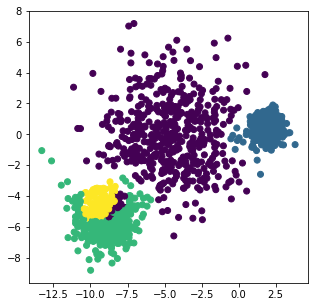

In [11]:
plt.figure(figsize=(5, 5))
number_of_clusters = 4     # 由上面的数据可知，当pc取10%分位数时，合适的类数应该为4类
largest_index = largest_index_trial[0 : number_of_clusters]
# print(largest_index)

# 聚类 -- Assignment
y_pred = np.zeros((n_samples, ), dtype=np.int16)

normal_cluster_mark = 1    # 对于正常的类别来说，编号为1至num_of_clusters.
outlier_cluster_mark = number_of_clusters + 1   # 异常值的点从num_of_clusters + 1开始编号

# 为找到的聚类中心赋予初始类别编号
for i in range(0, n_samples):
    if i in largest_index:
        y_pred[i] = normal_cluster_mark
        normal_cluster_mark = normal_cluster_mark + 1
        if nearest_higher_density_index[i] < 0:
            nearest_higher_density_index[i] = n_samples + 999
    elif nearest_higher_density_index[i] < 0:
        y_pred[i] = outlier_cluster_mark
        outlier_cluster_mark = outlier_cluster_mark + 1
        nearest_higher_density_index[i] = n_samples + 999

# 为剩余所有点进行类别指派
while 1:
    flag = True
    for i in range(0, n_samples):
        if nearest_higher_density_index[i] >= n_samples or y_pred[i] > 0:  # 若该点已分类或本身就是密度最大值点，则不再进行指派
            pass
        elif y_pred[nearest_higher_density_index[i]] > 0:                  # 若其近邻已经指派完毕，则将其类别指派至当前点     
            y_pred[i] = y_pred[nearest_higher_density_index[i]]
        else:                                                              # 若仍存在未指派类别的点，记flag为False
            flag = False
    if flag is True:                                                       # 若所有点均已指派完毕，则跳出循环
        break

# print(y_pred)
plt.scatter(X[:, 0], X[:, 1], c=y_pred)

由图可知，当dc选取为距离矩阵的10%分位数时，聚类的合适结果应选取为四类。该算法又进一步将第一类划分为两类，这也表明，dc的选择不同，会导致聚类算法实际上是会受到一定影响的。

## Part 5 : 结论

与传统聚类算法相比，新型聚类算法的确能够在聚类结果上展现出其优势，其在聚类的准确性上相对更高，并且适应性更强，能够适应多种不同形状和分布的类别数据，其在运算时无须迭代，计算开销也会相对更小，然而，dc的选择会对聚类结果造成影响，并且如何根据聚类图确定合适的类数仍为该算法可能存在的限制，此外，该算法还需计算点与点两两之间的距离，其在空间上可能也要花费相对较大的代价。